In [1]:
# PROTOTYPE Code for energy reconstruction
# Ready to read simulations from CORSIKA/Coreas
# This implementation is object oriented
# Date: September 16, 2019

# Written by Bruno L. Lago

In [2]:
#%cd /mnt/d/Pesquisa/GitHub/grandEnergyRec

In [3]:
from modERec import EnergyRec
import numpy as np

* EnergyRec default values summary:
--> bool_plot =  False
--> bool_EarlyLate =  False
--> nu_low =  50
--> nu_high =  200
--> SNR_thres =  10
--> thres_low =  1e-07
--> thres_high =  1
--> f_thres =  0.01




In [4]:
# Global variables
sim_dir = '/home/ubuntu/grand/chuv_estrela_80'

# Declare an instance of the reconstruction class

In [5]:
# Change some of the default values
EnergyRec.SNR_thres = 0.
EnergyRec.f_thres =  0.
EnergyRec.thres_low = 0.
EnergyRec.Antenna.bool_offset = 0
EnergyRec.thres_high = np.inf

In [6]:
rec1 = EnergyRec(sim_dir,9000)

* EnergyRec instance starting values summary:
--> bool_plot =  False
--> bool_EarlyLate =  False
--> nu_low =  50
--> nu_high =  200
--> SNR_thres =  0.0
--> thres_low =  0.0
--> thres_high =  inf
--> f_thres =  0.0


In [7]:
rec1.simulation_inspect()

* Simulation summary:
--> thetaCR =  79.99999767 deg
--> phiCR =  162.6200013 deg
--> E =  100000000.0 GeV
--> Core position =  (0., 0., 2800.) m
--> Geomagnetic field =  (2.82000008e-05, 0., 4.75e-05) T


# Read trace files

This block reads a sample trace file with columns $t, E_1, E_2, E_3$ and plots the signals.
Include the time offset and cut the time interval to speed up.

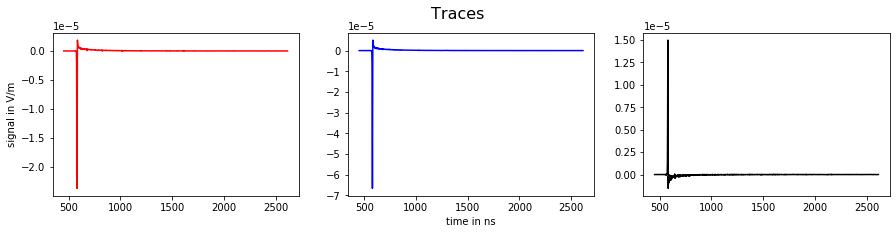

In [8]:
rec1.bool_plot = 1
rec1.antenna.bool_plot=1
rec1.inspect_antenna(70)
#rec1.antenna.offset_and_cut()

In [9]:
rec1.bool_plot = 0
rec1.antenna.bool_plot=0
rec1.Eval_fluences()

* Evaluating the fluences:
--> 0 % complete;
--> 10 % complete;
--> 20 % complete;
--> 30 % complete;
--> 40 % complete;
--> 50 % complete;
--> 60 % complete;
--> 70 % complete;
--> 80 % complete;
--> 90 % complete;
--> 100 % complete;




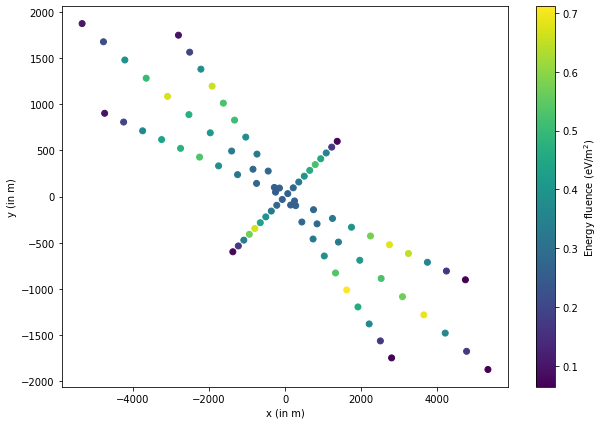

In [10]:
rec1.bool_plot = 1
rec1.antenna.bool_plot = 1
rec1.read_antpos()

<IPython.core.display.Javascript object>


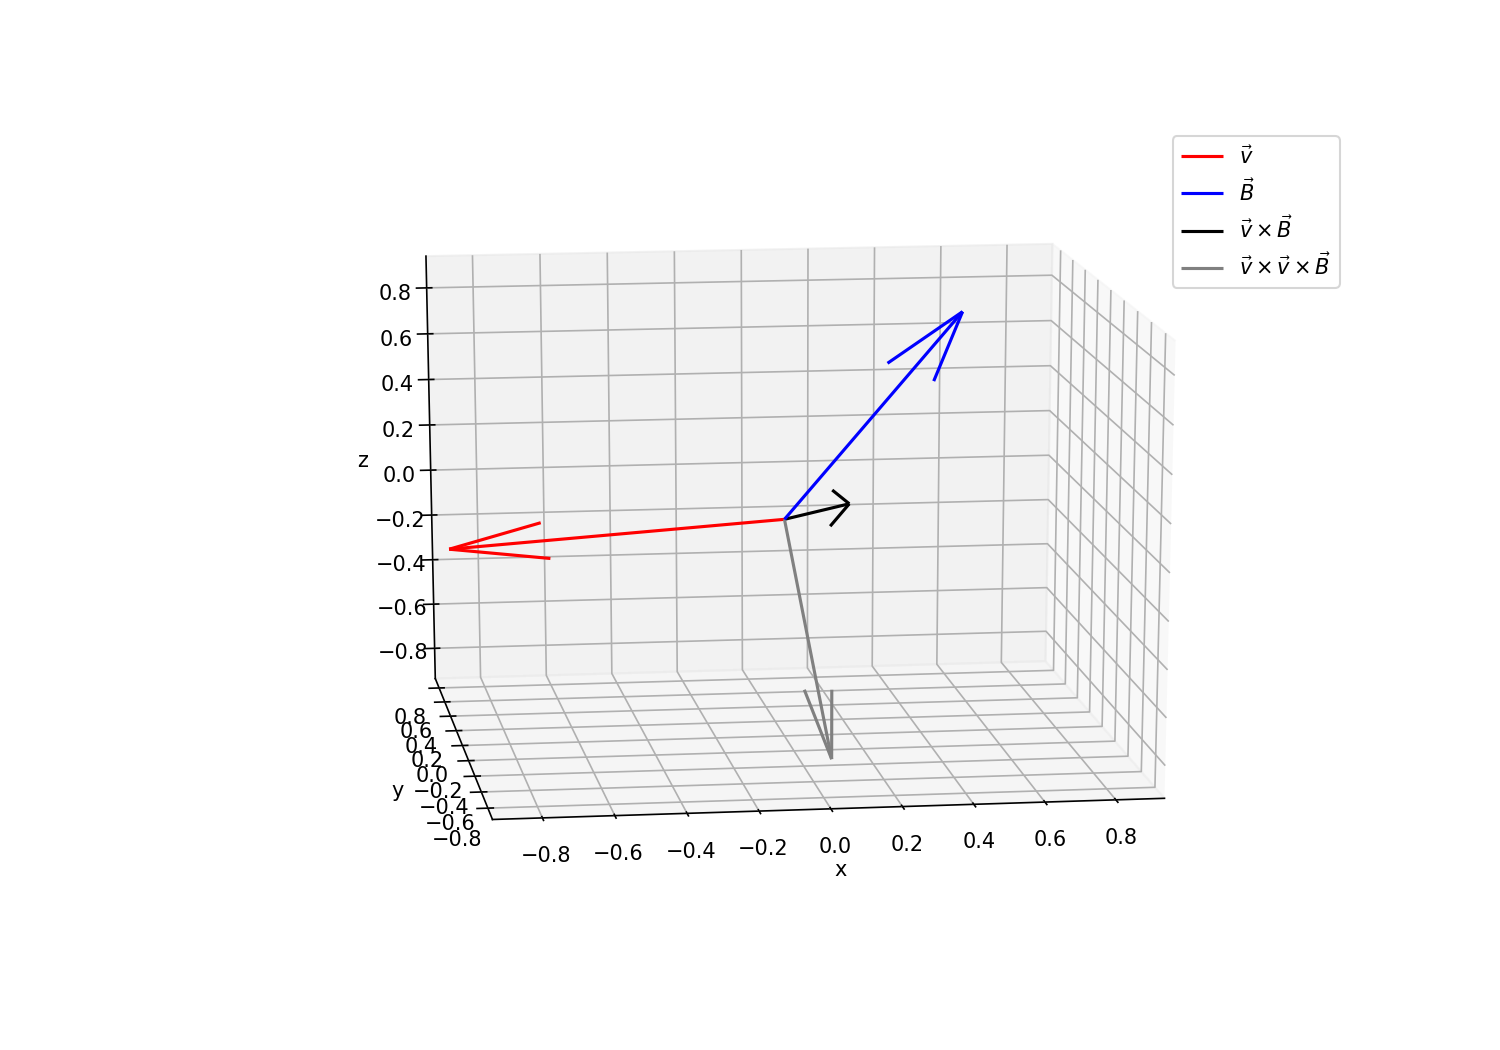

128.98412689663954 deg


In [11]:
%matplotlib notebook
rec1.shower_projection()
print(np.arccos(np.dot(rec1.shower.ev,rec1.shower.eB)).to("deg"))

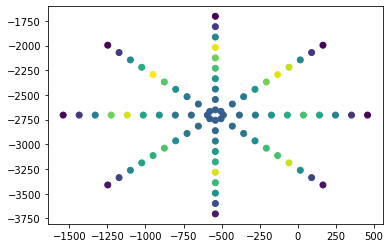

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
x = rec1.shower.r_proj[:,0]
y = rec1.shower.r_proj[:,1]
fluence = rec1.fluence_arr
plt.scatter(x[fluence>=0], y[fluence>=0], c=fluence[fluence>=0], cmap='viridis')


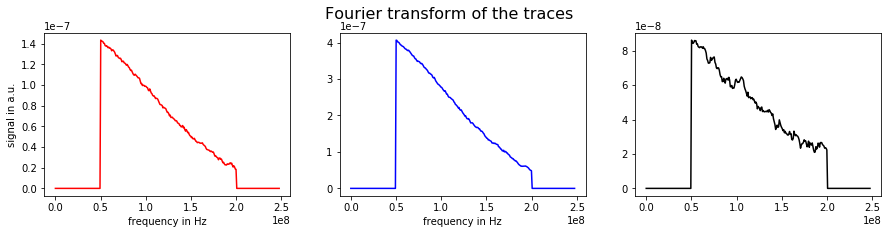

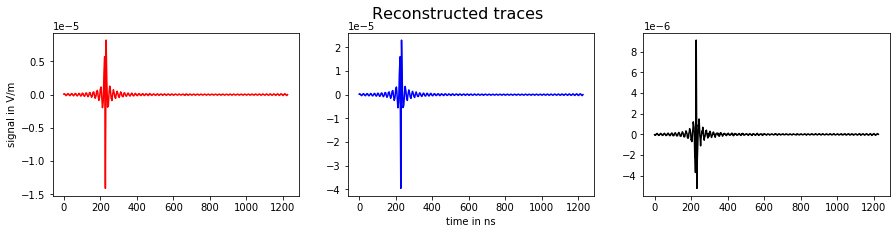

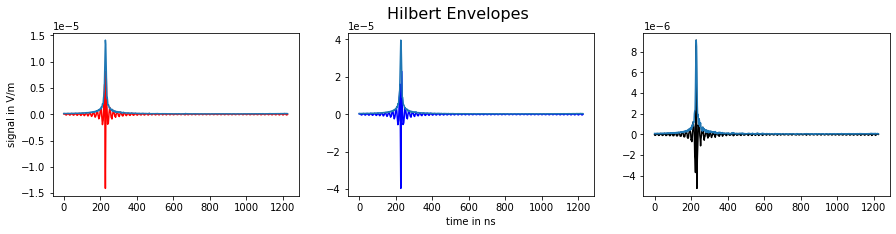

0.2586593765838217


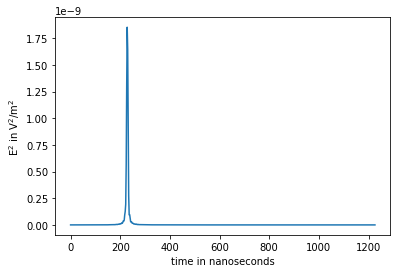

In [13]:
rec1.process_antenna(70)
print(rec1.antenna.fluence)

# FFT and filter
This block defines a function that performs the Fourier Transform and filters the result between 50 MHz and 200 MHz.


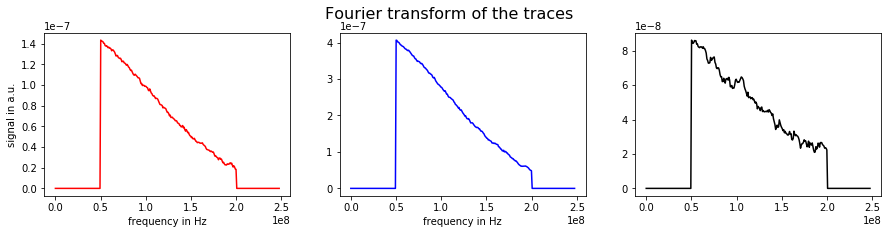

In [14]:
rec1.antenna.fft_filter()

# Reconstruct the trace
This block defines a function that reconstructs the traces.

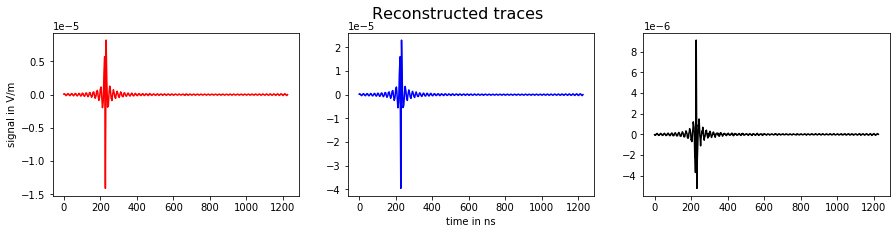

In [15]:
rec1.antenna.trace_recover()

# Hilbert envelope
This block defines a function to compute the Hilbert envelope of the reconstructed signal.

$$\mathcal{H}\{f(x)\}:=H(x)=\frac{1}{\pi}{\rm p.v.}\int_{-\infty}^\infty \frac{f(u)}{u-x}{\rm d}u$$

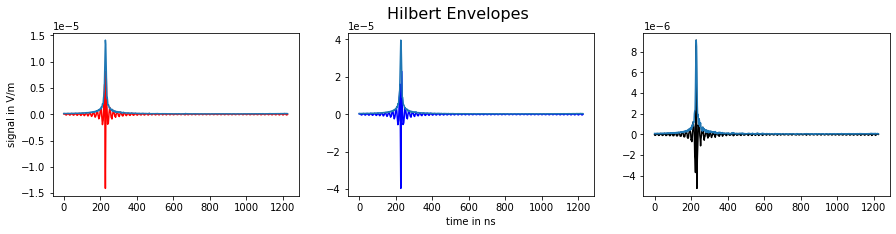

In [16]:
rec1.antenna.hilbert_envelope()

# Evaluate the energy fluence

The Hilbert transform of the reconstructed signals are squared a summed. The square root of the result is used to evaluate the signal and the background, so that the energy fluence $f$ is given by

$$ f = \epsilon_0 c\left(\Delta t \sum_{t_1}^{t_2} \left| \vec{E}(t_i)\right|^2- \Delta t \frac{t_2-t_1}{t_4-t_3} \sum_{t_3}^{t_4} \left| \vec{E}(t_i)\right|^2 \right) $$

Both intervals (for signal and background) are 200 ns wide.

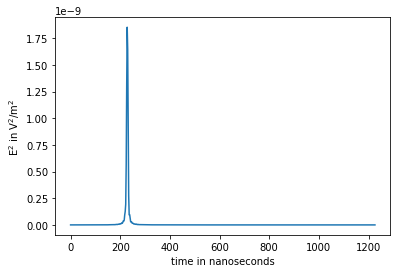

In [17]:
rec1.antenna.compute_fluence(rec1.shower.evB,rec1.shower.evvB)

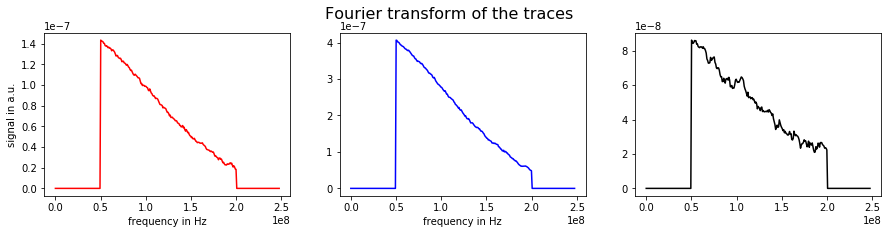

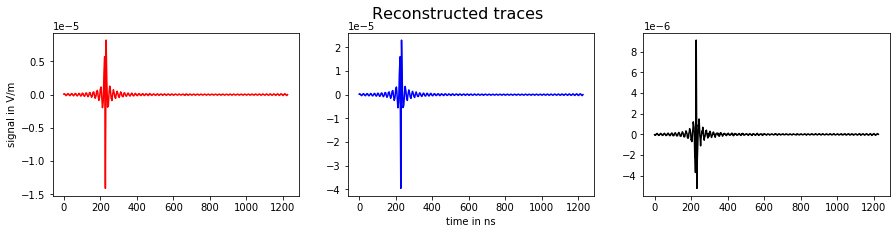

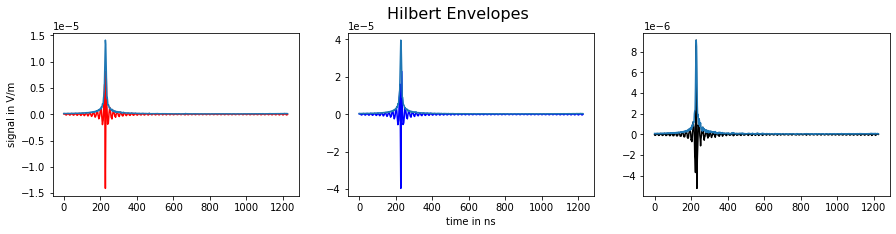

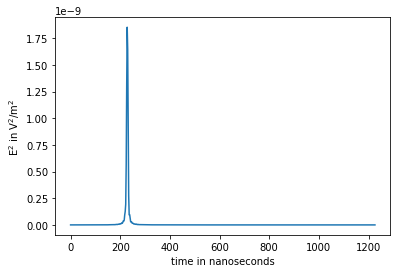

In [18]:
rec1.antenna.bool_plot=1 # Toggle plots on
rec1.process_antenna(70)
rec1.antenna.bool_plot=0

# Read all the traces and evaluates the fluences
The following blocks reads the names of all the trace files and evaluates the energy fluence for each antenna.

In [19]:
rec1.Eval_fluences()

* Evaluating the fluences:
--> 0 % complete;
--> 10 % complete;
--> 20 % complete;
--> 30 % complete;
--> 40 % complete;
--> 50 % complete;
--> 60 % complete;
--> 70 % complete;
--> 80 % complete;
--> 90 % complete;
--> 100 % complete;




## Read the antenna positions and plot the fluence
This block reads the antenna position file (whose columns are $x, y, z$) and plots the positions and corresponding fluence of each antenna.

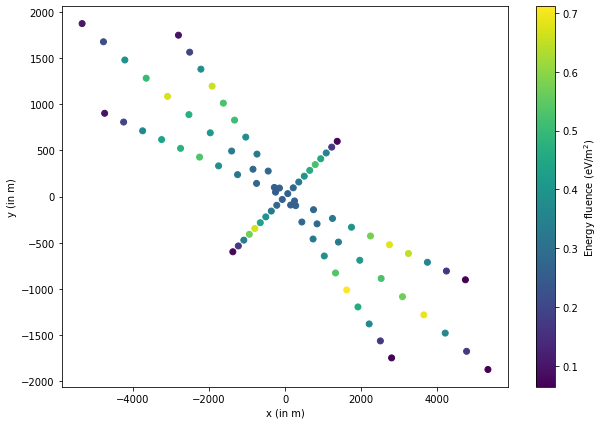

In [20]:
rec1.bool_plot=1 # Toggle plots on
rec1.read_antpos()
rec1.bool_plot = 0

# Fitting procedure

## Model function
This block defines the model function

$$f(\vec{r})=A\left[\exp\left(\frac{-(\vec{r}+C_{1}\vec{e}_{\vec{v}\times\vec{B}}-\vec{r}_{{\rm core}})^{2}}{\sigma^{2}}\right)-C_{0}\exp\left(\frac{-(\vec{r}+C_{2}\vec{e}_{\vec{v}\times\vec{B}}-\vec{r}_{{\rm core}})^{2}}{\left(C_{3}e^{C_{4}\sigma}\right)^{2}}\right)\right].$$


## The $\chi^2$
This block defines the $\chi^2$ to be minimized.

I included an uncertainty of $\sqrt{fluence}$ for each antenna.

## Project the antenna array into the shower plane
The two following blocks read the simulation input data (cosmic ray arrival direction and magnetic field), project the array into the shower plane.

The implementation evaluates the vectors $\hat{v},\quad \hat{B}, \quad \hat{e}_{\vec{v}\times\vec{B}}\,\quad {\rm and} \,\quad \hat{e}_{\vec{v}\times\vec{v}\times\vec{B}}$ in order to perform the projection.

In [21]:
rec1.simulation_inspect()
rec1.shower_plane();
rec1.antenna.bool_plot = 1
rec1.shower_projection();
rec1.antenna.bool_plot = 0

* Simulation summary:
--> thetaCR =  79.99999767 deg
--> phiCR =  162.6200013 deg
--> E =  100000000.0 GeV
--> Core position =  (0., 0., 2800.) m
--> Geomagnetic field =  (2.82000008e-05, 0., 4.75e-05) T


# Straightfoward fit

The following block performs all the steps described above and fits the aera LDF to the data.

In [22]:
rec1 = EnergyRec(sim_dir,9000)
rec1.simulation_inspect()
rec1.Eval_fluences()
rec1.model_fit()

* EnergyRec instance starting values summary:
--> bool_plot =  False
--> bool_EarlyLate =  False
--> nu_low =  50
--> nu_high =  200
--> SNR_thres =  0.0
--> thres_low =  0.0
--> thres_high =  inf
--> f_thres =  0.0
* Simulation summary:
--> thetaCR =  79.99999767 deg
--> phiCR =  162.6200013 deg
--> E =  100000000.0 GeV
--> Core position =  (0., 0., 2800.) m
--> Geomagnetic field =  (2.82000008e-05, 0., 4.75e-05) T
* Evaluating the fluences:
--> 0 % complete;
--> 10 % complete;
--> 20 % complete;
--> 30 % complete;
--> 40 % complete;
--> 50 % complete;
--> 60 % complete;
--> 70 % complete;
--> 80 % complete;
--> 90 % complete;
--> 100 % complete;


* Model fit:
** AERA fit:
--->  Par       Initial    Bestfit
--->  ----------------------------
--->  A           0.711     1.1792
--->  sigma         300   681.3934
--->  C0            0.5     0.8171
--->  C1            -10    -6.5205
--->  C2             20    35.8046
--->  C3             16     0.6509
--->  C4           0.01     0.0094
-

In [23]:
#rec1.signal_output()

In [24]:
#!rm fluence_ShowerPlane_45.out # to remove the old file

#for i in range(3010,3019):
#    rec1.bool_EarlyLate = 1 # if you want the early-late correction
#    print("Simulation: ",i)
#    rec1 = EnergyRec(sim_dir,i)
#    rec1.simulation_inspect()
#    rec1.Eval_fluences()
#    rec1.model_fit()
#    rec1.signal_output() # if you want to output the signal for the all shower analysis
    
#!mv bestfit.out bestfit_45.out

In [25]:
#rec1.model_fit()
#rec1.signal_output() # if you want to output the signal for the all shower analysis

## Plot the resulting fit and data

S_radio= 2033803.71


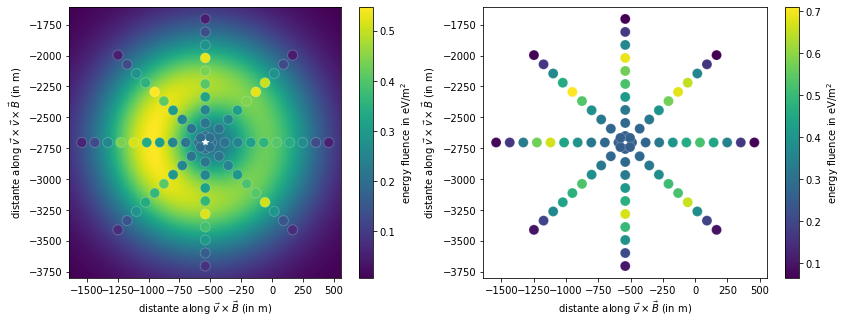

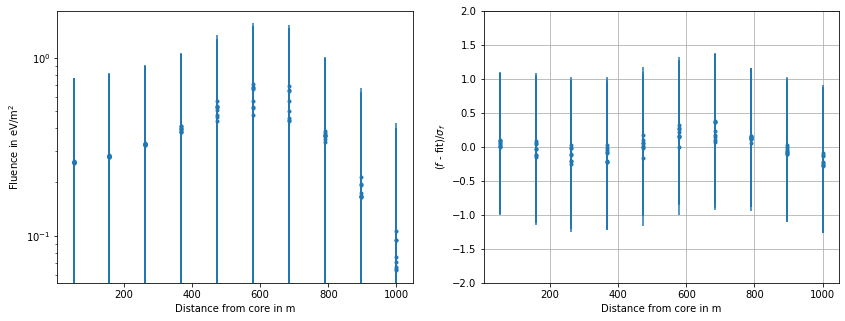

In [26]:
EnergyRec.AERA.aeraPlot(rec1)

# The MCMC sampling

The following block performs a MCMC sampling using the Metropolis-Hastings algorithm.

In [33]:
EnergyRec.MCMC.metropolis_hastings(rec1)

* Performing the MCMC sampling:
--> 0% complete;
--> 10 % complete;
--> 20 % complete;
--> 30 % complete;
--> 40 % complete;
--> 50 % complete;
--> 60 % complete;
--> 70 % complete;
--> 80 % complete;
--> 90 % complete;
--> 100 % complete;


# Plot the p.d.f.s and 2D contours

* Performing MCMC statistics:
** 1D analysis:
---> p.d.f for par:  A         --> Integral: cl1 =   0.6804  ; cl2 =   0.9519
---> p.d.f for par:  $\sigma$  --> Integral: cl1 =   0.6905  ; cl2 =   0.9748
---> p.d.f for par:  $C_0$     --> Integral: cl1 =   0.6808  ; cl2 =   0.9514
---> p.d.f for par:  $C_1$     --> Integral: cl1 =    0.724  ; cl2 =    0.957
---> p.d.f for par:  $C_2$     --> Integral: cl1 =   0.6847  ; cl2 =   0.9502
---> p.d.f for par:  $C_3$     --> Integral: cl1 =   0.6902  ; cl2 =   0.9831
---> p.d.f for par:  $C_4$     --> Integral: cl1 =   0.6805  ; cl2 =   0.9588
** 2D analysis:
---> 2D contour for par: ( $C_0$ , $C_1$ ) --> Integral: cl1 =   0.6953  ; cl2 =   0.9513
---> 2D contour for par: ( $C_0$ , $C_2$ ) --> Integral: cl1 =   0.6884  ; cl2 =   0.9605
---> 2D contour for par: ( $C_0$ , $C_3$ ) --> Integral: cl1 =   0.6953  ; cl2 =   0.9536
---> 2D contour for par: ( $C_0$ , $C_4$ ) --> Integral: cl1 =   0.6812  ; cl2 =    0.955
---> 2D contour for par: ( $C_1$

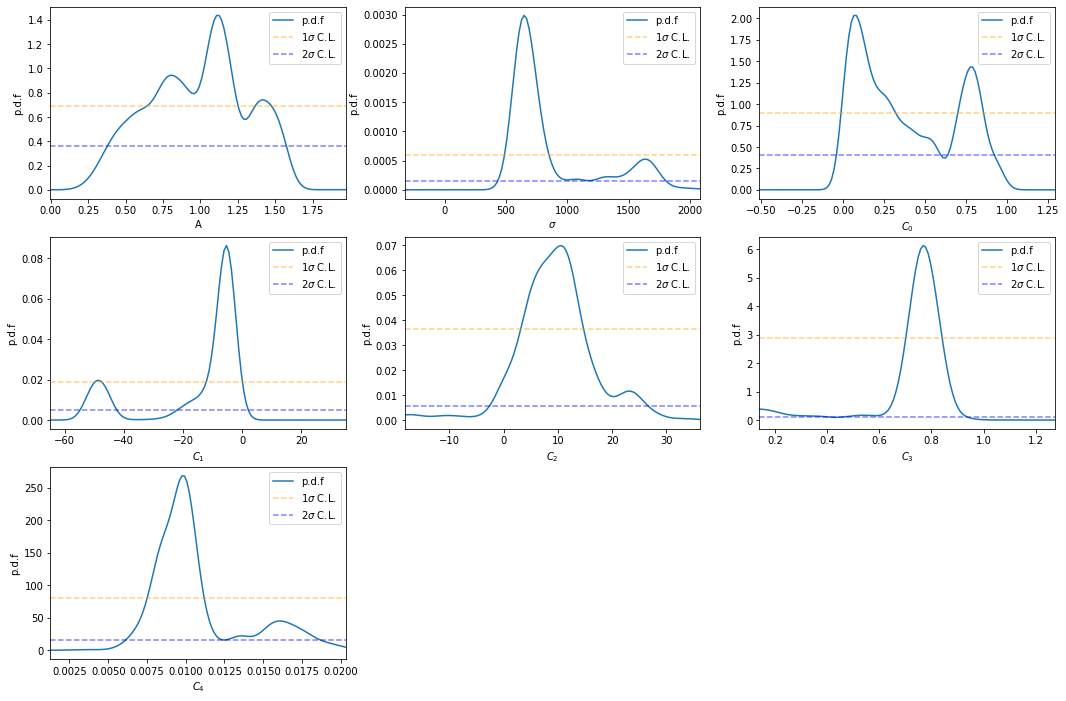

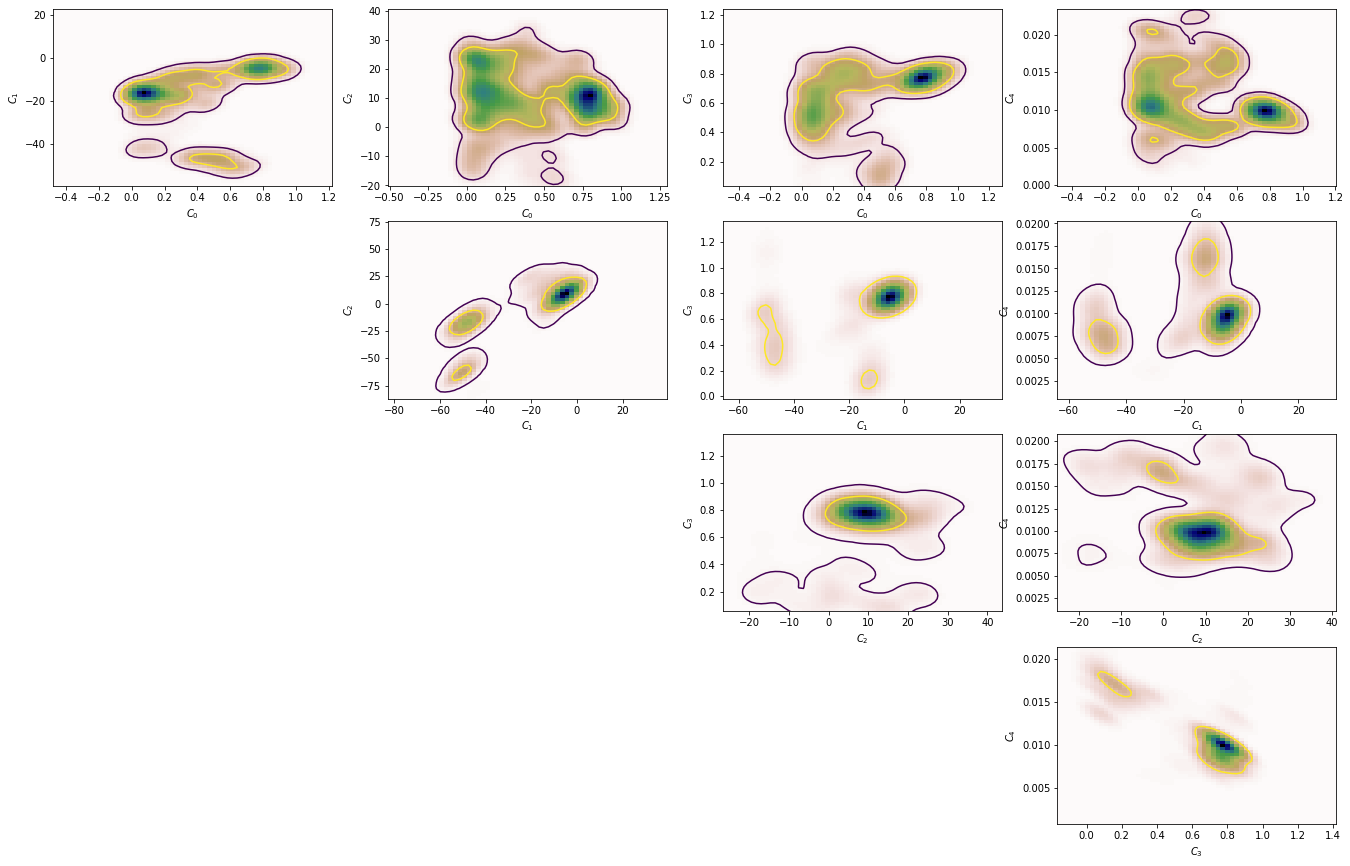

In [34]:
EnergyRec.MCMC.plotContour_MCMC(rec1)

In [40]:
print(type(rec1.GRANDshower.maximum.xyz))

<class 'astropy.units.quantity.Quantity'>


* Model fit:
--> Early-late correction applied
** AERA fit:
--->  Par       Initial    Bestfit
--->  ----------------------------
--->  A           0.767     1.6279
--->  sigma         300   554.2743
--->  C0            0.5      0.868
--->  C1            -10    27.2677
--->  C2             20    21.2964
--->  C3             16     7.6508
--->  C4           0.01     0.0071
--->  ----------------------------
--->  Chi2min/n.d.o.f =  2.49  /  73


S_radio= 1507977.59


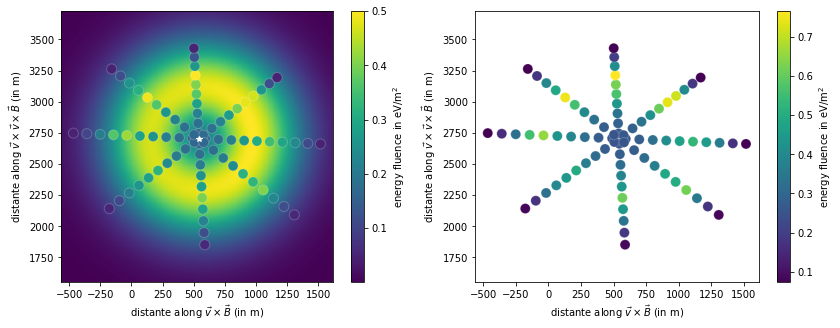

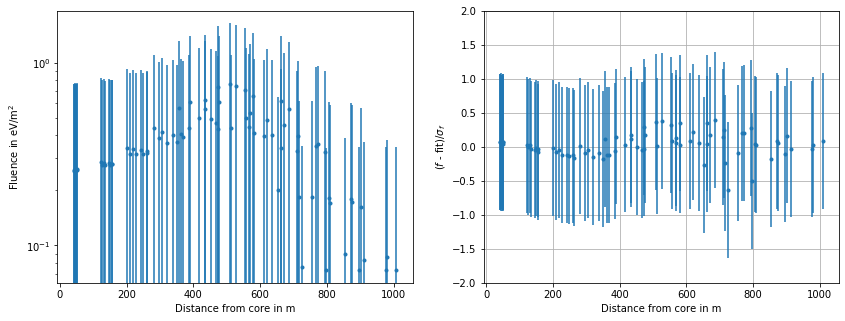

In [23]:
rec1.bool_EarlyLate = 1
rec1.model_fit()
EnergyRec.AERA.aeraPlot(rec1)

In [ ]:
EnergyRec.MCMC.metropolis_hastings(rec1)
EnergyRec.MCMC.plotContour_MCMC(rec1)

In [ ]:
from modERec import EnergyRec
import numpy as np

In [ ]:
sim_dir = '../simulation/sim_coreas_muller_1E17_45-65/'
rec1 = EnergyRec(sim_dir,6005)

In [ ]:
rec1.simulation_inspect()
rec1.shower.shower_plane()
rec1.Eval_geo_ch_fluences()